#### 1. fetch data

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Datasets loaded by Scikit-Learn generally have a similar dictionary structure, including:\
- A 'DESCR' key describing the dataset
- A 'data' key containing an array with one row per instance and one column per feature
- A 'target' key containing an array with the labels

In [2]:
X, y = mnist["data"], mnist["target"]
X.shape  # 70000 images, each has 784 features (28x28 pixels)

(70000, 784)

In [3]:
y.shape

(70000,)

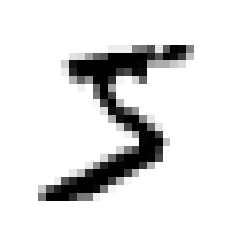

In [4]:
# take a look at one image
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [5]:
y[0]

'5'

#### 2. split train & test

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
# training set is already shuffled

#### 3. train a binary classifier

In [7]:
# 5-detector: distinguishes between 5 and not-5
y_train_5 = (y_train == '5')  # True for all 5s, False for all other digits
y_test_5 = (y_test == '5')

In [8]:
# SGD training --> independent handling of each instances, efficient for large data
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42) # to get reproducible results
sgd_clf.fit(X_train, y_train_5)

sgd_clf.predict([some_digit])

array([ True])

#### 4. measure performance

__4.1 Accuracy__ (using cross-validation)

In [9]:
# method 1: use cross_val_score()
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy") # only output scores

array([0.95035, 0.96035, 0.9604 ])

In [10]:
# method 2: implement cross-validation on your own
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

#skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
skfolds = StratifiedKFold(n_splits=3)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


BUT, for such a skewed dataset (less than 10% are 5s), even a very dumb classifier (classify every single image as not-5) can reach an accuracy of 90%.

__4.2 Confusion Matrix__

In [11]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)  # output the predictions on each test fold

In [12]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred) 
# row: actual class (row-1: not-5)
# column: predicted class (column-1: not-5)
# [true negatives, false positives]
# [false negatives, true positives]

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

__4.3 Precision and Recall__

In [13]:
# precision = TP / (TP + FP)
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [14]:
# recall = TP / (TP + FN)
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [15]:
# F1 score: harmonic mean of precision and recall
# F1 = 2 / (1/precision + 1/recall)

from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

_"precision-recall trade-off"_: cannot increase both at the same time

In [16]:
# make decisions by manipulating the threshold
y_scores = sgd_clf.decision_function([some_digit])  # the score of the first '5' sample
y_scores

array([2164.22030239])

In [17]:
# default threshold=0 in SGDClassifier
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [18]:
# raise the threshold
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

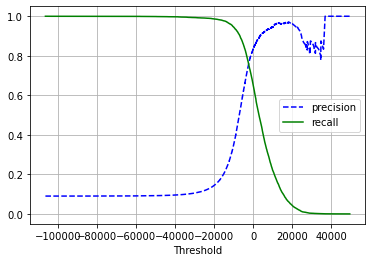

In [21]:
# to get the scores of the whole training set
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="recall")
    plt.legend(loc='right')
    plt.grid()
    plt.xlabel('Threshold')
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [24]:
# to threshold according to targeted precision --> but NOT the higher, the better
import numpy as np

threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

#### 4.4 The ROC Curve
The _receiver operating characteristic_ curve is a common tool used with binary classifiers.\
It plots the _true positive rate_ (recall, _sensitivity_) against the _false positive rate_ (FPR).\
FPR = 1 - TNR. (TNR: _true negative rate_, also called _specificity_)

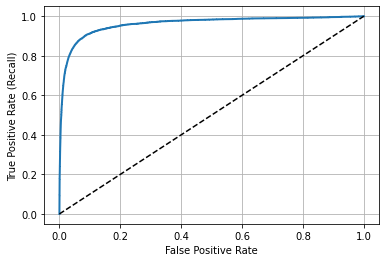

In [26]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.grid()
    
plot_roc_curve(fpr, tpr)
plt.show()

TPR (recall): TP / (TP + FN)\
FPR         : FP / (FP + TN)

In [27]:
# to compare the classifiers by _area under the curve_ (AUC)
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

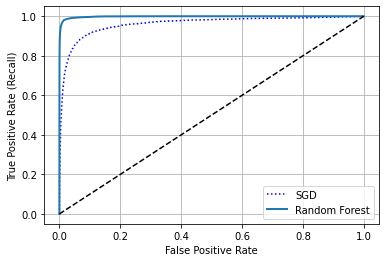

In [28]:
# train a random forest classifier and compare to it
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

y_scores_forest =  y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

The random forest classifier's ROC curve looks much better than SGD classifier's:
- closer to the top-left corner
- thus larger AUC